In [1]:
using Turing, Distributions, Random, MCMCChains, Plots, StatsPlots, Measures, BSON
# Random seed for reproducibility
Random.seed!(1234)

TaskLocalRNG()

In [5]:
# Define the Overhypothesis model using Turing
@model function dirichlet_multinomial_model(K, I, n, y)
    # Priors
    alpha ~ truncated(Exponential(0.5), 0.1, Inf)  # Keep alpha strictly positive
    beta ~ Dirichlet([0.5, 0.5])  # Prior for the base distribution

    # Small positive constant to ensure all values are positive
    epsilon = 1e-6

    # Container-specific color distributions
    theta = Vector{Vector{Real}}(undef, I)
    for i in 1:I
        concentration_param = alpha * beta .+ epsilon
        
        # Safeguard: check if concentration_param contains Inf or NaN values
        if any(isinf.(concentration_param)) || any(isnan.(concentration_param)) || any(concentration_param .<= 0)
            error("Invalid concentration parameters detected: ", concentration_param)
        end

        theta[i] ~ Dirichlet(concentration_param)

        # Ensure theta[i] values are above a minimum threshold
        min_threshold = 1e-6
        theta[i] = [max(val, min_threshold) for val in theta[i]]

        # Normalize theta[i] to make sure it sums to 1
        theta_sum = sum(theta[i])
        theta[i] = theta[i] / theta_sum

        # Ensure that theta[i] is a valid probability vector
        if any(isnan.(theta[i])) || any(theta[i] .< 0) || abs(sum(theta[i]) - 1.0) > epsilon
            error("Invalid probability vector detected: ", theta[i])
        end

        y[i, :] ~ Multinomial(n[i], theta[i])
    end
end


dirichlet_multinomial_model (generic function with 2 methods)

In [2]:
#Mixed group data
sample_vectors_mixed = [
    [0, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2],  
    [0, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1],  
    [0, 1, 1, 2, 2, 1, 1, 2, 2, 1, 2], 
    [0, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2],  
    [0, 1, 2, 2, 1, 1, 2, 1, 2, 1, 2], 
    [0, 2, 2, 1, 1, 2, 2, 1, 1, 1, 2], 
    [0, 1, 1, 1, 2, 2, 2, 1, 2, 1, 2],  
    [0, 2, 2, 1, 2, 2, 1, 2, 1, 1, 2],  
    [0, 1, 2, 1, 2, 2, 1, 2, 1, 1, 1], 
    [0, 2, 1, 1, 2, 1, 2, 1, 1, 2, 2],  
    [0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
]
#Uniform group data
sample_vectors_uniform = [
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],  
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],  
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],  
    [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], 
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],  
    [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],  
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],  
    [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],  
    [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], 
    [0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]  #Test
]


11-element Vector{Vector{Int64}}:
 [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
 [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
 [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
 [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
 [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
 [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
 [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
 [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
 [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
 [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
 [0, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [13]:
# Function to fit the model incrementally using the subsets, plus an additional test2 container
function fit_dynamic_model_test(sample_vectors)
    subset_index = 1
    n_containers = length(sample_vectors)
    all_posteriors = []

    # Iterate through each container and build up the subsets
    for container_index in 1:length(sample_vectors) #For each container
        for sample_index in 1:length(sample_vectors[container_index]) #For each sample 
            # Build the current subset
            subset = [i < container_index ? sample_vectors[i] : sample_vectors[i][1:sample_index] for i in 1:container_index]

            # Prepare the counts (y) for the model
            I = length(subset)  # Number of containers in the subset
            K = 2  # Number of item types (2; Low and High value in this case)
            y = [zeros(Int, K) for _ in 1:I]  # Initialize y based on K

            # Populate y based on the current subset
            for i in 1:I
                for val in subset[i]
                    if val == 1
                        y[i][1] += 1  # First category (e.g., Low-value)
                    elseif val == 2
                        y[i][2] += 1  # Second category (e.g., High-value)
                    elseif val == 0
                        y = y #A zero indicates an empty draw
                    else
                        error("Invalid sample value: $val. Must be 0, 1 or 2.")
                    end
                end
            end

            # Prepare n based on the current subset
            n = [length(s)-1 for s in subset]  # Total counts for each container in the subset
            
            #If the current container is the test1 container (i.e. last container)
            if I == length(sample_vectors)
                push!(y, [0,0]) #Append a new container (test2), with no observation
                push!(n, 0) #Count items in new container (always 0)
                I = I+1 #Lengthen I by the additional container
            end
            
            # Print the current subset and the corresponding y element
            println("Subset $subset_index: $subset")
            println("y element for model: $y")
            println("I: $I")
            println("n: $n\n")

            # Fit the model with the current subset
            model = dirichlet_multinomial_model(K, I, n, y)
            chain = sample(model, NUTS(), 1000, progress = false)

            # Store the posterior samples in a dictionary
            posterior_samples = Dict()
            for param in names(chain)
                posterior_samples[string(param)] = chain[param]
            end
            push!(all_posteriors, posterior_samples)

            subset_index += 1
        end
    end
    
    return all_posteriors
end

fit_dynamic_model_test (generic function with 1 method)

In [3]:
# Fit the model with the sample_vectors
#all_posteriors_uniform = fit_dynamic_model_test(sample_vectors_uniform)
#all_posteriors_mixed = fit_dynamic_model_test(sample_vectors_mixed)
# Save the posteriors
#BSON.@save "Models/level2_mixed.bson" all_posteriors_mixed
#BSON.@save "Models/level2_uniform.bson" all_posteriors_uniform

# Load posteriror samples
BSON.@load "Posterior_Samples/level2_mixed.bson" all_posteriors_mixed
BSON.@load "Posterior_Samples/level2_uniform.bson" all_posteriors_uniform

In [6]:
#This code creates indeces to extract the posterior samples of theta for the last container and test container of each model fit.
all_posteriors = copy(all_posteriors_mixed)
sample_vectors = copy(sample_vectors_mixed)

n_samples = sum([length(s) for s in sample_vectors])
n_containers = length(sample_vectors)

# Combined function to create current_container and current_sample indices
function create_indices(sample_vectors::Vector{Vector{Int}})
    current_container = Int[]  # Initialize an empty array to hold the container indices
    current_sample = Int[]     # Initialize an empty array to hold the sample indices

    # Iterate through each container and its samples
    for (container_index, samples) in enumerate(sample_vectors)
        # Append the container index for each sample in the container
        append!(current_container, [container_index for _ in samples])

        # Append the sample index for each sample in the container
        append!(current_sample, [i-1 for i in 1:length(samples)])
    end

    return current_container, current_sample
end

current_container, current_sample = create_indices(sample_vectors)

test1 = copy(current_container)
test2 = copy(current_container)

#This replaces the last container (test1) with the last container + 1 (test2)
test2 = append!(test2[1:end-length(sample_vectors[end])], fill(current_container[end]+1, length(sample_vectors[end])))

141-element Vector{Int64}:
  1
  1
  1
  1
  1
  1
  1
  1
  1
  1
  1
  2
  2
  ⋮
 12
 12
 12
 12
 12
 12
 12
 12
 12
 12
 12
 12

[ Info: Saved animation to /Users/aruf650/Library/CloudStorage/OneDrive-Personal/Uni/PhD/Research/Overhypothesis/Analysis/Cognitive_Model/Julia/Models/theta_evolution_full.gif


Plots.AnimatedGif("/Users/aruf650/Library/CloudStorage/OneDrive-Personal/Uni/PhD/Research/Overhypothesis/Analysis/Cognitive_Model/Julia/Models/theta_evolution_full.gif")
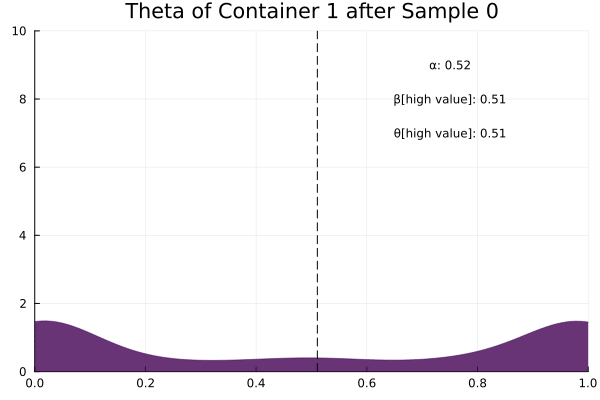

In [19]:
# Function to animate the evolution of theta posteriors for the last container in each iteration
function animate_theta_evolution_all_containers(all_posteriors, current_container)
    #Define current_container
    current_container = current_container
    # Define a color palette for the containers
    container_colors = palette(:viridis, n_containers+1)

    # Create an animation object
    anim = @animate for i in 1:n_samples
        # Extract the samples for theta of the last container
        last_container = current_container[i]
        last_sample = current_sample[i]
        theta_samples = vec(all_posteriors[i]["theta[$last_container][2]"])

        # Extract alpha and beta samples for this iteration
        alpha_samples = vec(all_posteriors[i]["alpha"])
        beta_samples = vec(all_posteriors[i]["beta[2]"])  # Assuming beta[2] is the probability for white marbles

        # Calculate medians
        theta_median = median(theta_samples)
        alpha_median = median(alpha_samples)
        beta_median = median(beta_samples)

        # Get the color for the current container
        fill_color = container_colors[last_container]

        # Plot the density for the last container's theta and fill the area under the curve
        p = plot(xlims = (0, 1), ylims = (0, 10), legend = false,
                 title = "Theta of Container $last_container after Sample $last_sample")
        density!(theta_samples, fill = true, fillalpha = 0.8, alpha = 0.5, color = fill_color)

        # Show the median line for theta
        vline!([theta_median], color = :black, linestyle = :dash, linewidth = 1)
        
        # Annotate with the median values of theta, alpha, and beta
        annotate!(0.75, 9, text("α: $(round(alpha_median, digits=2))", 8))
        annotate!(0.75, 8, text("β[high value]: $(round(beta_median, digits=2))", 8))
        annotate!(0.75, 7, text("θ[high value]: $(round(theta_median, digits=2))", 8))
    end

    # Display the animation
    gif(anim, "theta_evolution_full.gif", fps = 10)
end

# Example usage
animate_theta_evolution_all_containers(all_posteriors_mixed, test1)

[ Info: Saved animation to /Users/aruf650/Library/CloudStorage/OneDrive-Personal/Uni/PhD/Research/Overhypothesis/Analysis/Cognitive_Model/Julia/Models/theta_evolution_test.gif


Plots.AnimatedGif("/Users/aruf650/Library/CloudStorage/OneDrive-Personal/Uni/PhD/Research/Overhypothesis/Analysis/Cognitive_Model/Julia/Models/theta_evolution_test.gif")
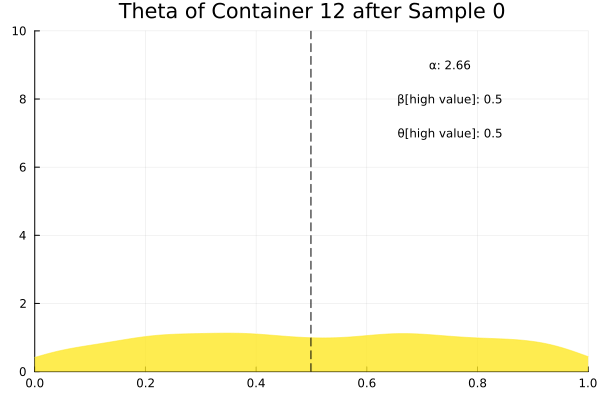

In [9]:
# Function to animate the evolution of theta posteriors for the last container in each iteration
function animate_theta_evolution_test(all_posteriors, current_container)
    #Define current_container
    current_container = current_container
    # Define a color palette for the containers
    container_colors = palette(:viridis, n_containers+1)


    start_last_container = length(current_sample)-length(sample_vectors[end])+1
    # Create an animation object
    anim = @animate for i in start_last_container:length(current_sample)
        # Extract the samples for theta of the last container
        last_container = current_container[i]
        last_sample = current_sample[i]
        theta_samples = vec(all_posteriors[i]["theta[$last_container][2]"])

        # Extract alpha and beta samples for this iteration
        alpha_samples = vec(all_posteriors[i]["alpha"])
        beta_samples = vec(all_posteriors[i]["beta[2]"])  # Assuming beta[2] is the probability for white marbles

        # Calculate medians
        theta_median = median(theta_samples)
        alpha_median = median(alpha_samples)
        beta_median = median(beta_samples)

        # Get the color for the current container
        fill_color = container_colors[last_container]

        # Plot the density for the last container's theta and fill the area under the curve
        p = plot(xlims = (0, 1), ylims = (0, 10), legend = false,
                 title = "Theta of Container $last_container after Sample $last_sample")
        density!(theta_samples, fill = true, fillalpha = 0.8, alpha = 0.5, color = fill_color)

        # Show the median line for theta
        vline!([theta_median], color = :black, linestyle = :dash, linewidth = 1)
        
        # Annotate with the median values of theta, alpha, and beta
        annotate!(0.75, 9, text("α: $(round(alpha_median, digits=2))", 8))
        annotate!(0.75, 8, text("β[high value]: $(round(beta_median, digits=2))", 8))
        annotate!(0.75, 7, text("θ[high value]: $(round(theta_median, digits=2))", 8))
    end

    # Display the animation
    gif(anim, "theta_evolution_test.gif", fps = 2)
end

# Example usage
animate_theta_evolution_test(all_posteriors_mixed, test2)

[ Info: Saved animation to /Users/aruf650/Library/CloudStorage/OneDrive-Personal/Uni/PhD/Research/Overhypothesis/Analysis/Cognitive_Model/Julia/Models/theta_evolution_combined_dark.gif


Plots.AnimatedGif("/Users/aruf650/Library/CloudStorage/OneDrive-Personal/Uni/PhD/Research/Overhypothesis/Analysis/Cognitive_Model/Julia/Models/theta_evolution_combined_dark.gif")
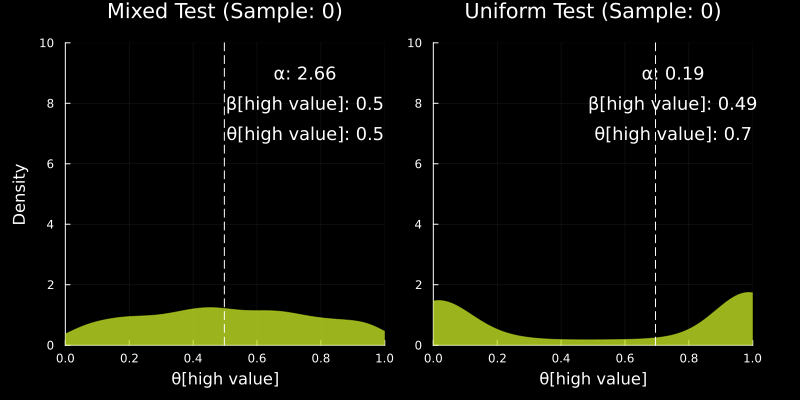

In [77]:
using Plots
gr()  # Use GR backend for animation

# Modified function to animate two sets of posterior evolutions side by side
function animate_theta_evolution_combined(all_posteriors1, all_posteriors2, current_container)
    n_containers = maximum(current_container)  # Number of containers for color palette
    container_colors = palette(:viridis, n_containers + 1)  # Define color palette

    # Define the starting point for the animation loop
    start_last_container = length(current_sample) - length(sample_vectors[end]) + 1

    # Create an animation object
    anim = @animate for i in start_last_container:length(current_sample)
        # Extract information for the first posterior set
        container1 = current_container[i]
        sample1 = current_sample[i]
        theta_samples1 = vec(all_posteriors1[i]["theta[$container1][2]"])
        alpha_samples1 = vec(all_posteriors1[i]["alpha"])
        beta_samples1 = vec(all_posteriors1[i]["beta[2]"])

        # Calculate medians for the first posterior set
        theta_median1 = median(theta_samples1)
        alpha_median1 = median(alpha_samples1)
        beta_median1 = median(beta_samples1)

        # Extract information for the second posterior set
        container2 = current_container[i]
        sample2 = current_sample[i]
        theta_samples2 = vec(all_posteriors2[i]["theta[$container2][2]"])
        alpha_samples2 = vec(all_posteriors2[i]["alpha"])
        beta_samples2 = vec(all_posteriors2[i]["beta[2]"])

        # Calculate medians for the second posterior set
        theta_median2 = median(theta_samples2)
        alpha_median2 = median(alpha_samples2)
        beta_median2 = median(beta_samples2)

        # Get the fill color for both containers
        fill_color1 = container_colors[container1]
        fill_color2 = container_colors[container2]

        # Create the first plot for the first posterior set
        p1 = plot(xlims = (0, 1), ylims = (0, 10), legend = false,
                  title = "Mixed Test (Sample: $sample1)",
                  xlab = "θ[high value]",
                  ylab = "Density",
                  background_color = :black, fg_color = :white,
                  bottom_margin = 5mm, left_margin = 5mm)
        
        density!(theta_samples1, fill = true, fillalpha = 0.8, alpha = 0.5, color = fill_color1)
        vline!([theta_median1], color = :white, linestyle = :dash, linewidth = 1)
        annotate!(0.75, 9, text("α: $(round(alpha_median1, digits=2))", 12, :white))
        annotate!(0.75, 8, text("β[high value]: $(round(beta_median1, digits=2))", 12, :white))
        annotate!(0.75, 7, text("θ[high value]: $(round(theta_median1, digits=2))", 12, :white))

        # Create the second plot for the second posterior set
        p2 = plot(xlims = (0, 1), ylims = (0, 10), legend = false,
                  title = "Uniform Test (Sample: $sample2)",
                  xlab = "θ[high value]",
                  background_color = :black, fg_color = :white,
                  top_margin = 5mm, right_margin = 10mm)
        
        density!(theta_samples2, fill = true, fillalpha = 0.8, alpha = 0.5, color = fill_color2)
        vline!([theta_median2], color = :white, linestyle = :dash, linewidth = 1)
        annotate!(0.75, 9, text("α: $(round(alpha_median2, digits=2))", 12, :white))
        annotate!(0.75, 8, text("β[high value]: $(round(beta_median2, digits=2))", 12, :white))
        annotate!(0.75, 7, text("θ[high value]: $(round(theta_median2, digits=2))", 12, :white))

        # Combine the two plots side by side
        combined_plot = plot(p1, p2, layout = (1, 2), size = (800, 400))

        # Return the combined plot for this frame
        combined_plot
    end

    # Save the animation as a GIF
    gif(anim, "theta_evolution_combined_dark.gif", fps = 1)
end

# Example usage
animate_theta_evolution_combined(all_posteriors_mixed, all_posteriors_uniform, test1)
